# Lab 02: Multiple and Logistic regression

Author: **N.J. de Winter** (*n.j.de.winter@vu.nl*)<br>
Assitant Professor Vrije Universiteit Amsterdam<br>
Statistics and Data Analysis Course

## Learning goals:

* Practice your skills interpreting and modifying Python code 
* Understand and apply tools to test which *independent variables* in a larger dataset are relevant to predict the *dependent variable* (multiple regression
* Learn how to apply *regression* analysis to determine the *relationship* between multiple variables:
    * Multiple linear regression (straight line relationships between multiple variables)
    * Logistic regression (Logistic, or *sigmoid*-shaped relationships between multiple variables)

## Introduction
In this lab, we will get familiar with multiple regression and logistic regression using Python. Make sure you have completed Lab 01 first before starting on this one, because we will assume all the concepts in the first lab are familiar to you now. As a consequence, in this lab, there will be less "hand holding" and you will need to figure out more Python coding yourself. We will also assume from now on that the Jupyter format is familiar to you, although you are also still free to run the code in your own Spyder environment. If you ever get lost trying to get something done in Python, you can always go back to Lab 01 to check for examples about how to code things.

We will start again by loading the Python *packages* we need in this lab:

In [1]:
# Make sure our figures show up in Jupyter
%matplotlib inline
import numpy as np # The 'numpy' package contains some handy functions
import pandas as pd # The 'pandas' package helps us to import and manage data
import scipy.stats as stats # The 'scipy' package contains statistical formulas we need
import statsmodels.api as sm # The 'statsmodels' package contains the functions we need to run regression models
from matplotlib import pyplot as plt # The 'matplotlib' package contains tools need to plot our results
from mpl_toolkits.mplot3d import Axes3D # This is a cool package for making 3D-plots!

## Part 1: Multiple regression
With that our of the way, we can load the dataset we need to do our multiple regression. We will start with the dataset `Lab02a.csv`.

__Exercise 1:__ Load the dataset here using the code box below. If you don't remember how to do this, look back to Lab01 and use the code you used there to load and inspect the data.

**Warning:** If you are working on this Lab (Lab02) in a different folder or environment on your computer than on Lab01 (which is a good idea!), make sure the data file is in the right place.

In [2]:
# Load the data for this assignment into Python and in the Jupyter environment.
df3 = pd.read_csv('Lab02a.csv')

# Inspect the first rows of the dataset to familiarize yourself again with this data
df3.head()

,x,y,perc_org,height
0,119.750646,47.913958,16.248034,9.079537
1,116.155693,47.117481,14.503663,14.509850
2,118.034213,47.577559,14.835459,13.251438
3,117.429912,46.669757,9.422610,15.621684
4,119.456495,47.164533,12.691097,11.748356


This data file lists measurements of organic matter content in soils. It contains the following variables:
* `x` (the x coordinate of the location)
* `y` (the y coordinate of the location)
* `height` (the height of the soil at these locations)
* `perc_org` (the percentage organic matter in the top 10 cm of the soil at these locations)

Soil organic matter content varies depending on location. We want to verify if there is systematic variability. For example, soil organic matter content may change in a certain direction because of elevation changes. In this case, we should be able to detect this difference along the x or y coordinates. If soil organic matter content increases in the x direction, there should be a positive correlation between soil organic matter content and x coordinates. If soil organic matter content increases along the diagonal between x and y coordinates, there should be positive correlations between soil organic matter content and both x and y. We could express this using a regression equation with both x and y as independent variables. First, we will check the relationship between soil organic matter, and the x and y coordinates.

__Question 1:__ How can we check whether there is a correlation between soil organic matter and x or y coordinates?

__Answer 1:__ We can calculate the correlation coefficients between the three variables.

In Lab01, we have assessed the correlations between variables one by one. This is feasible for relatively small datasets like this one, but quickly becomes tedious for larger datasets. Below you find a more efficient code to check correlations between all variables in a dataset. For it to work we first need to isolate the variables we are interested in:

In [3]:
df3_2 = df3.iloc[:, 0:3] # Isolate the first three columns of df3

__Exercise 2:__ Inspect the first rows of the newly created dataframe to make sure the function did what you wanted it to do:

In [4]:
# inspect the new dataframe `df2_3`
df3_2.head()

,x,y,perc_org
0,119.750646,47.913958,16.248034
1,116.155693,47.117481,14.503663
2,118.034213,47.577559,14.835459
3,117.429912,46.669757,9.422610
4,119.456495,47.164533,12.691097


Now we can use the function `corr()` to calculate correlation coefficients between the variables.

__NOTE__: This function `.corr` only works on `pandas` dataframes (loaded using `pd.read_csv()`), for more general purposes you can use the function `np.corrcoef()` from the `numpy` package.

In [5]:
A = df3_2.corr() # Create correlation matrix
print(A) # Print the result

                 x         y  perc_org
x         1.000000  0.062768  0.235113
y         0.062768  1.000000  0.869701
perc_org  0.235113  0.869701  1.000000


Notice that this is in fact the same function we used in Lab01, but without specifying the variables.

__Question 2:__ Does organic matter content correlate most strongly with the x or y coordinate? Why are there ones at the diagonal of the output matrix?

__Answer 2:__ Organic matter content correlates more strongly with the y coordinate. The ones are there because a variable alway correlates perfectly with itself (Pearson's r = 1)

__Exercise 3:__ Plot scatter plots between variables `x`, `y` and `perc_organic`. (Hint: have a look at the code in Lab01 if you do not remember how to do this).

Text(0, 0.5, 'Pecentage organic matter')

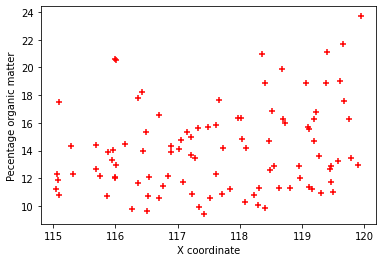

In [6]:
# Plot perc_org vs x coordinate
plt.scatter(df3_2.x, df3_2.perc_org, color = 'red', marker = '+')
plt.xlabel('X coordinate')
plt.ylabel('Pecentage organic matter')

Text(0, 0.5, 'Pecentage organic matter')

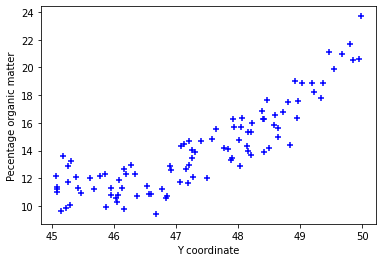

In [7]:
# Plot perc_org vs y coordinate
plt.scatter(df3_2.y, df3_2.perc_org, color = 'blue', marker = '+')
plt.xlabel('Y coordinate')
plt.ylabel('Pecentage organic matter')

Text(0, 0.5, 'Y coordinate')

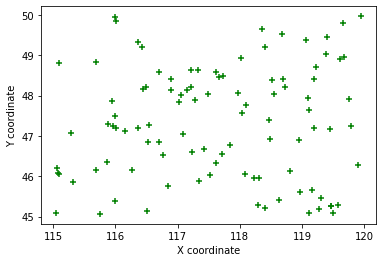

In [8]:
# Plot x vs y coordinate
plt.scatter(df3_2.x, df3_2.y, color = 'green', marker = '+')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

### Preparing data for multiple regression
We will now explore how well the combination of the two coordinates can predict the organic matter content in the soil. We will use a *multiple linear regression* to achive this. Running a multiple linear regression in Python is actually not that different from running a simple linear regression, but we need to prepare our data a little bit first:

In [9]:
# First we isolate the dependent variable (percentage organic matter)
Y = df3_2[['perc_org']]

In [10]:
# Then we group the independent variables (coordinates)
X = df3_2[['x', 'y']]

In [11]:
# Now, as with the polynomial regression, we need to add a constant (vector of ones) to tell Python that we want to include an intercept value in our regression
# The statsmodels package has a neat function to do this:
X = sm.add_constant(X)

__Exercise 4:__ Use the functions you have used before to inspect the newly created datasets `X` and `Y`:

In [12]:
X.head() # Inspect dataframe `X`

,const,x,y
0,1.0,119.750646,47.913958
1,1.0,116.155693,47.117481
2,1.0,118.034213,47.577559
3,1.0,117.429912,46.669757
4,1.0,119.456495,47.164533


In [13]:
Y.head() # Inspect dataframe `Y`

,perc_org
0,16.248034
1,14.503663
2,14.835459
3,9.422610
4,12.691097


For our multiple regression, we will use a slightly different function from the `statsmodels` package than the one we used in Lab01. The syntax is almost the same as `smf.ols`:

In [14]:
multreg1 = sm.OLS(Y, X).fit()

__Exercise 5:__ Use the code box below to print a summary of the multiple regression. (Hint: Use the same code you used in Lab01 to print summaries of simple linear regressions)

In [15]:
# Print a summary of the multiple linear regression
print(multreg1.summary())

                            OLS Regression Results                            
Dep. Variable:               perc_org   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     181.5
Date:                Thu, 05 Oct 2023   Prob (F-statistic):           1.65e-33
Time:                        09:24:25   Log-Likelihood:                -177.26
No. Observations:                 100   AIC:                             360.5
Df Residuals:                      97   BIC:                             368.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -123.8763     12.836     -9.650      0.0

__Question 3:__ Looking at the multiple regression overall, does the combination of independent variables accurately predict the value of the independent variable? Which regression metrics do you use to answer this question?

__Answer 3:__ Yes, the regression performed well, (adjusted) R2 = 0.79 and p-value of the regression is very low (<< 0.05)

__Question 4:__ Considering the contributions of the independent variables (x and y coordinates) separately, which variables significantly influence the dependent variable (organic matter content)? Which metrics do you use to answer this question?

__Answer 4:__ Both coordinates seem to have a significant effect (p < 0.05).

We will now use some of Python’s visualization capabilities to better understand the meaning of the regression coefficients. Our regression estimates the soil organic matter content P based on the equation $𝑃=𝑎+𝑏𝑥+𝑐𝑦$. This equation defines a surface in a 3-dimensional space with the axes x, y and P. The surface has to be calculated on equally spaced grid in x and y and is saved as zdata. We use  the `mpl_toolkits.mplot3d` package to achieve this. The zdata needs input coefficients from the multilinear regression for the constant, and the x and y variables. We can find these coefficients from the regression results using the `params` function.

__Exercise 6:__ To display the 3D surface, follow the steps below. Make sure you inspect the newly created dataframes so you understand every step.

In [16]:
# Prepare the equally spaced grid of x and y coordinates
xdata = range(int(np.floor(min(df3.x))), int(np.ceil(max(df3.x))), 1) # Create range of x values at equal intervals
ydata = range(int(np.floor(min(df3.y))), int(np.ceil(max(df3.y))), 1) # Create range of y values at equal intervals
grid = np.array([(x, y) for x in xdata for y in ydata]) # Combine the two ranges into a grid

In [17]:
# Inspect new x-y grid
print(grid)

[[115  45]
 [115  46]
 [115  47]
 [115  48]
 [115  49]
 [116  45]
 [116  46]
 [116  47]
 [116  48]
 [116  49]
 [117  45]
 [117  46]
 [117  47]
 [117  48]
 [117  49]
 [118  45]
 [118  46]
 [118  47]
 [118  48]
 [118  49]
 [119  45]
 [119  46]
 [119  47]
 [119  48]
 [119  49]]


In [18]:
# Calculate the z-data for each combination of x and y
zdata = multreg1.params[0] + multreg1.params[1] * grid[:, 0] + multreg1.params[2] * grid[:, 1]

In [19]:
# Inspect the new z data
print(zdata)

[ 8.54305781 10.4609738  12.37888978 14.29680577 16.21472176  8.94404149
 10.86195748 12.77987347 14.69778946 16.61570545  9.34502518 11.26294117
 13.18085715 15.09877314 17.01668913  9.74600886 11.66392485 13.58184084
 15.49975683 17.41767282 10.14699255 12.06490854 13.98282452 15.90074051
 17.8186565 ]


Text(0.5, 0, 'Organic Matter [%]')

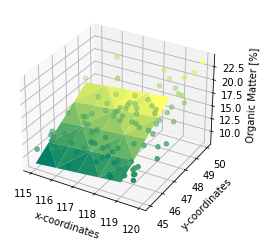

In [20]:
# Plot the 3D-plot
plt.figure(2) # initiate the plot
ax = plt.axes(projection = '3d') # Tell Python to create a 3D projection
ax.plot_trisurf(grid[:, 0], grid[:, 1], zdata, cmap = 'summer') # Create a 3D surface plot with values colored according to the "summer" colorscale
ax.scatter(df3.x, df3.y, df3.perc_org, c=df3.perc_org, cmap='summer') # Add the datapoints from which the surface is calculated in the same color scheme
ax.set_xlabel('x-coordinates') # label the x axis
ax.set_ylabel('y-coordinates') # label the y axis
ax.set_zlabel('Organic Matter [%]') # label the z axis

Maybe the soil organic matter content is not really determined by the x or y coordinates, but by another variable. Let’s add height as a variable.

__Exercise 7:__ Redo __Exercise 2__ and __Exercise 3__ after adding the height variable. Start by creating a scatterplot of height vs. organic matter percentage.

__WARNING:__ Be careful naming your objects to prevent overwriting something you may need later or confusing data!

Text(0, 0.5, 'Pecentage organic matter')

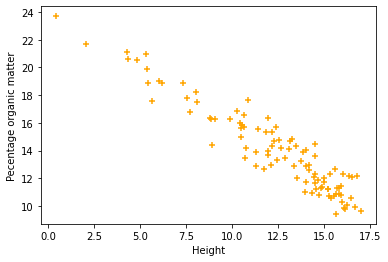

In [21]:
# Plot perc_org vs y coordinate
plt.scatter(df3.height, df3.perc_org, color = 'orange', marker = '+')
plt.xlabel('Height')
plt.ylabel('Pecentage organic matter')

In [22]:
# Prepare our data

# First we isolate the dependent variable (percentage organic matter)
Y2 = df3[['perc_org']]

# Then we group the independent variables (coordinates)
X2 = df3[['x', 'y', 'height']]

# Now we add a constant (vector of ones) to tell Python that we want to include an intercept value in our regression
X2 = sm.add_constant(X2)

# Run the regression
multreg2 = sm.OLS(Y2, X2).fit()

# Print a summary of the new multiple linear regression
print(multreg2.summary())

                            OLS Regression Results                            
Dep. Variable:               perc_org   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     292.7
Date:                Thu, 05 Oct 2023   Prob (F-statistic):           3.71e-48
Time:                        09:24:25   Log-Likelihood:                -139.22
No. Observations:                 100   AIC:                             286.4
Df Residuals:                      96   BIC:                             296.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.4887     16.296      1.196      0.2

__Question 5:__ What do you observe about the regression overall? Do the x and y coordinates still provide a statistically significant contribution at p < 0.05?

__Answer 5:__ The R2 value is much higher (0.9), so the regression has improved. The x and y coordinates do not have a significant effect any longer (p > 0.05)

In the end, elevation is the main determinant of soil organic matter content in our case study. Lower elevations have higher soil organic matter content. This may be because lower elevation locations are wetter and support more vegetation, and thus production of organic matter. It also takes longer to decompose organic matter in wet soils compared to dry soils. Another reason could be that erosion processes denude organic matter from higher elevation locations and deposit them at lower elevation locations.

The lesson here is that (multiple) regressions can only give you insight into the relationships between variables you add to the regression. If a variable (like `height` in this case) is missing, you may draw the wrong conclusions. Inspecting scatter plots and correlation matrices of all variables before (blindly) trying to do a regression could have warned you for this.

## Part 2: Logistic regression
We will practice with *Logistic regression* using the dataset `Lab02b.csv`.
Use the code box below to load it using Python code you are now familiar with

In [23]:
# Load the data for this assignment into Python and in the Jupyter environment.
df4 = pd.read_csv('Lab02b.csv')

We also need some additional functions and packages. The code below should load them for you.

In [24]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import seaborn as sns

Once you have imported the data, use the code box below to inspect it.

In [25]:
# Inspect the new dataframe
print(df4)

                 Name  GP   MIN  PTS  FG_PC  THREEP_Made  THREEP_PC  FTM  \
0      Brandon Ingram  36  27.4  7.4   34.7          0.5       25.0  1.6   
1     Andrew Harrison  35  26.9  7.2   29.6          0.7       23.5  2.6   
2      JaKarr Sampson  74  15.3  5.2   42.2          0.4       24.4  0.9   
3         Malik Sealy  58  11.6  5.7   42.6          0.1       22.6  0.9   
4         Matt Geiger  48  11.5  4.5   52.4          0.0        0.0  1.3   
...               ...  ..   ...  ...    ...          ...        ...  ...   
1335      Chris Smith  80  15.8  4.3   43.3          0.0       14.3  1.2   
1336      Brent Price  68  12.6  3.9   35.8          0.1       16.7  0.8   
1337     Marlon Maxey  43  12.1  5.4   55.0          0.0        0.0  1.0   
1338  Litterial Green  52  12.0  4.5   43.9          0.0       10.0  1.2   
1339        Jon Barry  47  11.7  4.4   36.9          0.4       33.3  0.7   

      FT_PC  REB  AST  STL  BLK  TOV  TARGET_5Yrs  
0      69.9  4.1  1.9  0.4  0.4  1.

__Question 6:__ Are there any values in this dataset which may cause you problems when doing data analysis?

__Answer 6:__ Yes, there are missing values in the dataset, but they are very hard to spot with the inspection commands (`head()` and `print()`)

It is likely that you did not find any problems with the dataset through your inspection. However, the dataset does in fact contain missing values (reported by Python as `NA`), but the dataset is large and they are somewhat hidden. You can use the combination of functions below to find them:

In [26]:
df4.isna().sum()

Name            0
GP              0
MIN             0
PTS             0
FG_PC           0
THREEP_Made     0
THREEP_PC      11
FTM             0
FT_PC           0
REB             0
AST             0
STL             0
BLK             0
TOV             0
TARGET_5Yrs     0
dtype: int64

__Exercise 8:__ Now that you know this, you may remove missing values using the `dropna()` command. You can do this in a similar way as when you inspect your dataset using `.head()` or when you detected the `NA` values with `.isna` and `sum()` above. Try it, and then verify that the `NA`'s are gone using the same function you used above.

In [27]:
# Remove the missing values from the dataset
df4_2 = df4.dropna()
# Check whether the new dataset has no NA's 
df4_2.isna().sum()

Name           0
GP             0
MIN            0
PTS            0
FG_PC          0
THREEP_Made    0
THREEP_PC      0
FTM            0
FT_PC          0
REB            0
AST            0
STL            0
BLK            0
TOV            0
TARGET_5Yrs    0
dtype: int64

The data file contains multiple variables of performance metrics from current and former basketball players in the NBA. For clarification, the variables abbreviations are explained in Table 1. Take a good look at these variables.

<center><b>Table 1</b> Abbreviation and explanation of different variables of NBA players.</center>

|Abbreviations|Explanation|
| :--- | :--- |
|GP|Games played|
|MIN|Minutes played per game|
|PTS|Points per game|
|FG_PC|Field goal % (shooting accuracy) per game|
|THREEP_Made|3 pointer made per game|
|THREEP_PC|3 pointer % (3 pointer shooting accuracy) per game|
|FTM|Free throw made per game|
|FT_PC|Free throw % (free throw shooting accuracy) per game|
|REB|Rebounds per game|
|AST|Assists per game|
|TARGET_5Yrs|Players lasted more than 5 years in the league or not|
|STL|Steals per game|
|BLK|Blocks per game|
|TOV|Turnovers per game (amount of lost balls)|

A number of variables are expressed as percentages, while others are expressed as a number of actions per game.

__Question 7:__ Do you think it is fair to compare performance per game knowing that the number of minutes played per game varies among the players?

__Answer 7:__ Probably not, we need to normalize for the number of minutes played per game.

To normalize for the number of minutes played per game, we will divide the `PTS`, `THREEP_Made`, `FTM`, `REB`, `AST`, `STL`, `BLK` and `TOV` by the `MIN` variable to derive the number of actions per minute. For the PTS variable, you can for example do this by using the following command and check the result using the `.head()` function, as you are used to:

In [28]:
df4_2['PTS_MIN'] = df4_2['PTS'] / df4_2['MIN']
df4_2.head()

C:\Users\niels\AppData\Local\Temp\ipykernel_31088\2769719319.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_2['PTS_MIN'] = df4_2['PTS'] / df4_2['MIN']


,Name,GP,MIN,PTS,FG_PC,THREEP_Made,THREEP_PC,FTM,FT_PC,REB,AST,STL,BLK,TOV,TARGET_5Yrs,PTS_MIN
0,Brandon Ingram,36,27.4,7.4,34.7,0.5,25.0,1.6,69.9,4.1,1.9,0.4,0.4,1.3,0,0.270073
1,Andrew Harrison,35,26.9,7.2,29.6,0.7,23.5,2.6,76.5,2.4,3.7,1.1,0.5,1.6,0,0.267658
2,JaKarr Sampson,74,15.3,5.2,42.2,0.4,24.4,0.9,67.0,2.2,1.0,0.5,0.3,1.0,0,0.339869
3,Malik Sealy,58,11.6,5.7,42.6,0.1,22.6,0.9,68.9,1.9,0.8,0.6,0.1,1.0,1,0.491379
4,Matt Geiger,48,11.5,4.5,52.4,0.0,0.0,1.3,67.4,2.5,0.3,0.3,0.4,0.8,1,0.391304


__NOTE__: The code above might trigger a "SettingWithCopyWarning", which is a warning by Python that you are making changes to your dataframe by modifying copies of elements of it (in this case the columns). You can ignore this warning for now, but if you are interested to find out why Python warns you for this you can look it up online. If you want to ignore this warning throughout the Python session, you can use the following code:

`pd.options.mode.chained_assignment = None  # default='warn'`

__Exercise 9:__ Normalize the other variables which depend on the number of minutes played in the same way using the code block below and inspect the result.

In [29]:
# Ignore the annoying warning
pd.options.mode.chained_assignment = None  # default='warn'

# Normalize values
df4_2['THREEP_Made_MIN'] = df4_2['THREEP_Made'] / df4_2['MIN']
df4_2['FTM_MIN'] = df4_2['FTM'] / df4_2['MIN']
df4_2['REB_MIN'] = df4_2['REB'] / df4_2['MIN']
df4_2['AST_MIN'] = df4_2['AST'] / df4_2['MIN']
df4_2['STL_MIN'] = df4_2['STL'] / df4_2['MIN']
df4_2['BLK_MIN'] = df4_2['BLK'] / df4_2['MIN']
df4_2['TOV_MIN'] = df4_2['TOV'] / df4_2['MIN']

# Inspect results
df4_2.head()

,Name,GP,MIN,PTS,FG_PC,THREEP_Made,THREEP_PC,FTM,FT_PC,REB,...,TOV,TARGET_5Yrs,PTS_MIN,THREEP_Made_MIN,FTM_MIN,REB_MIN,AST_MIN,STL_MIN,BLK_MIN,TOV_MIN
0,Brandon Ingram,36,27.4,7.4,34.7,0.5,25.0,1.6,69.9,4.1,...,1.3,0,0.270073,0.018248,0.058394,0.149635,0.069343,0.014599,0.014599,0.047445
1,Andrew Harrison,35,26.9,7.2,29.6,0.7,23.5,2.6,76.5,2.4,...,1.6,0,0.267658,0.026022,0.096654,0.089219,0.137546,0.040892,0.018587,0.059480
2,JaKarr Sampson,74,15.3,5.2,42.2,0.4,24.4,0.9,67.0,2.2,...,1.0,0,0.339869,0.026144,0.058824,0.143791,0.065359,0.032680,0.019608,0.065359
3,Malik Sealy,58,11.6,5.7,42.6,0.1,22.6,0.9,68.9,1.9,...,1.0,1,0.491379,0.008621,0.077586,0.163793,0.068966,0.051724,0.008621,0.086207
4,Matt Geiger,48,11.5,4.5,52.4,0.0,0.0,1.3,67.4,2.5,...,0.8,1,0.391304,0.000000,0.113043,0.217391,0.026087,0.026087,0.034783,0.069565


We will continue or analysis with the following variables: `GP`, `MIN`, `PTS_MIN`, `FG_PC`, `THREEP_Made_MIN`, `THREE_PC`, `FTM_MIN`, `FT_PC`, `REB_MIN`, `AST_MIN`, `TARGET_5Yrs`, `STL_MIN`, `BLK_MIN`, `TOV_MIN`. The aim of the exercise is to tell which performance metrics influence whether a player lasts more than five years in the NBA league.

Logistic regression analysis is used to predict the outcome of a dependent categorical variable. In other words, the regression analysis assesses the chances that the outcome of the dependent variable is either 1 (yes, success, etc.) or 0 (no, failure, etc.). Hence, the dependent variable is a binary variable.

__Question 8:__ Based on your knowledge of logistic regression and the data file (Table 1). Which variable is the binary dependent variable we will predict?

__Answer 8:__ The dependent variable is `Target_5yrs` (whether or not the player is still in the NBA after 5 years)

The dataset is extensive and complex, but could easily be expanded with more variable variables (e.g. the position on the basketball court, age, etc.). Can you think of other variables? With a logistic regression, you can assess which variables have influence on a player’s success to last longer than five years in the NBA league.

First, we will explore which performance metrics may influence a player’s success to last longer than 5 years in the NBA league. You can group players based on whether or not they played longer than 5 years in the NBA. After this, you can plot the values of the different performance metrics for those players that played longer than five years in the NBA with those that did not. You can use boxplots to visualize the results. For the GP variable, this for example results in the following command:

<AxesSubplot:xlabel='TARGET_5Yrs', ylabel='GP'>

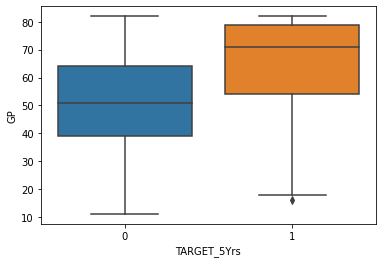

In [30]:
sns.boxplot(x = df4_2.TARGET_5Yrs, y = df4_2.GP, data = df4_2)

__Exercise 10:__ Do the same for all other performance metrics.

<AxesSubplot:xlabel='TARGET_5Yrs', ylabel='TOV_MIN'>

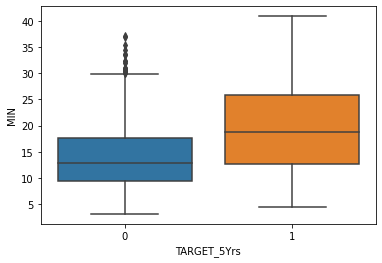

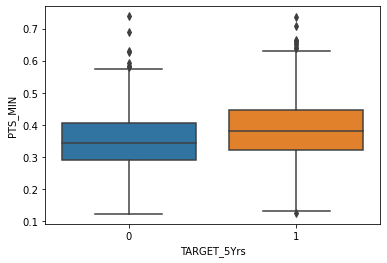

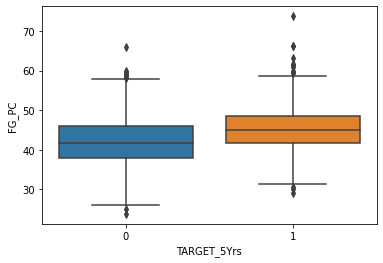

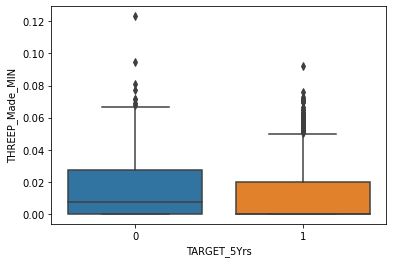

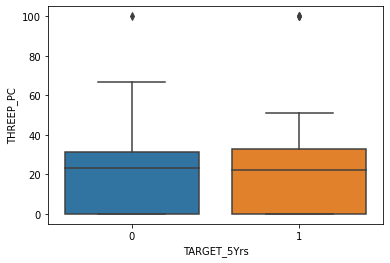

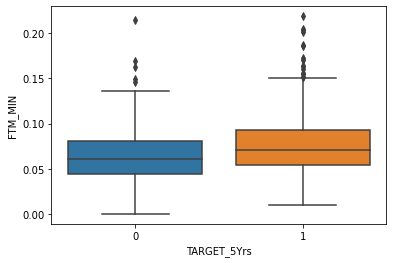

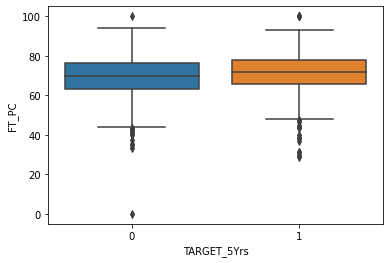

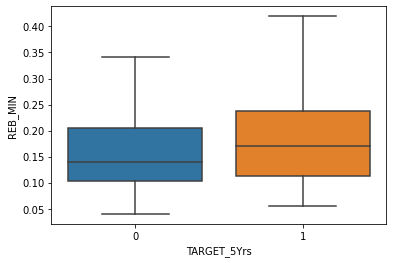

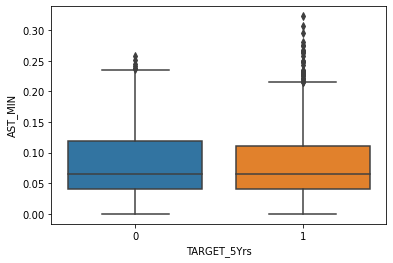

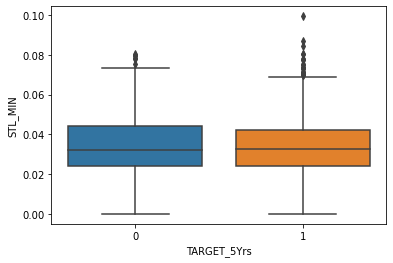

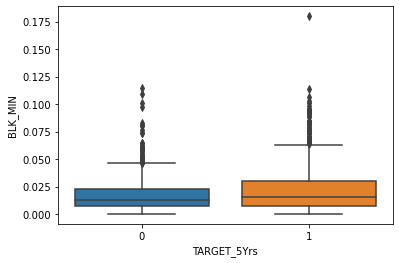

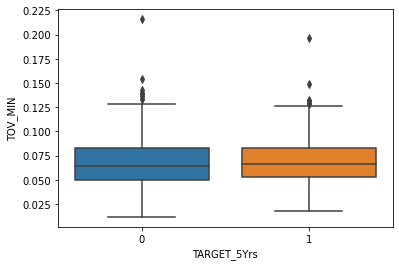

In [31]:
# Plot boxplots of all other variables
plt.figure(1)
sns.boxplot(x = df4_2.TARGET_5Yrs, y = df4_2.MIN, data = df4_2)
plt.figure(2)
sns.boxplot(x = df4_2.TARGET_5Yrs, y = df4_2.PTS_MIN, data = df4_2)
plt.figure(3)
sns.boxplot(x = df4_2.TARGET_5Yrs, y = df4_2.FG_PC, data = df4_2)
plt.figure(4)
sns.boxplot(x = df4_2.TARGET_5Yrs, y = df4_2.THREEP_Made_MIN, data = df4_2)
plt.figure(5)
sns.boxplot(x = df4_2.TARGET_5Yrs, y = df4_2.THREEP_PC, data = df4_2)
plt.figure(6)
sns.boxplot(x = df4_2.TARGET_5Yrs, y = df4_2.FTM_MIN, data = df4_2)
plt.figure(7)
sns.boxplot(x = df4_2.TARGET_5Yrs, y = df4_2.FT_PC, data = df4_2)
plt.figure(8)
sns.boxplot(x = df4_2.TARGET_5Yrs, y = df4_2.REB_MIN, data = df4_2)
plt.figure(9)
sns.boxplot(x = df4_2.TARGET_5Yrs, y = df4_2.AST_MIN, data = df4_2)
plt.figure(10)
sns.boxplot(x = df4_2.TARGET_5Yrs, y = df4_2.STL_MIN, data = df4_2)
plt.figure(11)
sns.boxplot(x = df4_2.TARGET_5Yrs, y = df4_2.BLK_MIN, data = df4_2)
plt.figure(12)
sns.boxplot(x = df4_2.TARGET_5Yrs, y = df4_2.TOV_MIN, data = df4_2)

__Question 9:__ What do you observe? Which performance metrics seem to influence a player’s success to last longer than five years in the NBA league? Do the variables with positive and negative influences seem logical? Does any of the findings seem counterintuitive?

__Answer 9:__

Positive influence: `GP`, `MIN`, `PTS_MIN`, `FG_PC`, `FTM_MIN`, `REB_MIN`

Negative influence: `THREE_Made_MIN`

No influence: `THREE_PC`, `FT_PC`, `AST_MIN`, `STL_MIN`, `BLK_MIN`, `TOV_MIN`

The variables with positive influences are logical. The negative influence of THREE_Made_MIN is counterintuitive


The function sns.countplot is a good way to investigate which number of players made it for more than five years in the NBA league:

<AxesSubplot:xlabel='TARGET_5Yrs', ylabel='count'>

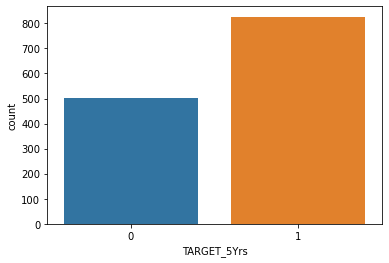

In [32]:
sns.countplot(x = df4_2.TARGET_5Yrs, data = df4_2)

Now, we will perform a logistic regression analysis with the `statsmodels` function `sm.Logit` which you loaded earlier.

__Exercise 11:__ We first need to define all the predictors (independent variables) and the dependent variables. You can do this in the same way as you did in the multiple regression exercises above (if you forgot, check the code above __Exercise 2__):

In [33]:
# Define independent variables
X = df4_2[['GP', 'MIN', 'PTS_MIN', 'FG_PC', 'THREEP_Made_MIN', 'THREEP_PC', 'FTM_MIN', 'FT_PC', 'REB_MIN', 'AST_MIN', 'STL_MIN', 'BLK_MIN', 'TOV_MIN']]

# Define dependent variables
y = df4_2[['TARGET_5Yrs']]

After this, we can perform the logistic regression and print its results:

In [34]:
logit_model = sm.Logit(y,X).fit()
print(logit_model.summary2())

Optimization terminated successfully.
         Current function value: 0.574917
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.133     
Dependent Variable: TARGET_5Yrs      AIC:              1554.1302 
Date:               2023-10-05 09:24 BIC:              1621.6286 
No. Observations:   1329             Log-Likelihood:   -764.07   
Df Model:           12               LL-Null:          -881.55   
Df Residuals:       1316             LLR p-value:      1.8541e-43
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
-----------------------------------------------------------------
GP                0.0351   0.0046  7.6782 0.0000   0.0262  0.0441
MIN               0.0390   0.0105  3.7173 0.0002   0.0184  0.0595


__Question 10:__ Which performance metrics have a significant influence at a player’s success to last longer than five years in the NBA league at p < 0.05?

__Answer 10:__ Successful performance metrics are: `GP`, `MIN`, `FG_PC`, `FTM_MIN`, `FT_PC`, `TOV_MIN`

Before performing another logistic regression model with less variables, it is good to understand the information in the regression summary. In the summary, the coefficient values are values that describe how each predictor influences the outcome of a player lasting longer than five years in the NBA league. For example, the variable games played (`GP`) is significant at p < 0.05. This tells you that for every unit increase in `GP`, the log odds of lasting longer than years (versus lasting less than 5 years) increases by 0.035.

Another variable, turnovers per game divided by minutes played (`TOV_MIN`), also significantly contributes in the model at p < 0.05. For every unit increase in the `TOV_MIN`, the log odds of a player lasting longer than five years in the NBA league *decreases* with 10.391 (it has a negative coefficient). Thus, numeric increases in some performance metrics positively influence the odds of lasting longer than 5 years in the NBA. For other performance metrics, increases in numeric values negatively influence the chance of lasting longer than five years in the NBA league.

__Question 11:__ Which significant predictor variables, at p < 0.05, show the largest positive and negative influence on a player staying in the NBA for more than five years? Which predictors variables do not have a significant influence at p < 0.05 and could thus be taken out of the model? Are any of the findings counterintuitive?

__Answer 11:__ The largest positive influence on success is `FTM_MIN`, while the largest negative influence is `TOV_MIN`. `PTS_MIN`, `THREEP_Made_MIN`, `THREEP_PC`, `REB_MIN`, `AST_MIN`, `STL_MIN` and `BLK_MIN` have no influence. It is somewhat counterintuitive that `FG_PC` and `FT_PC` have a negative influence on a player's chances to last longer than 5 years in the NBA, and one would perhaps expect that steals and threepointers would have a bigger influence.

__Exercise 12:__ Execute another logistic regression with only the performance metrics that were significant at p < 0.05 in the previous regression.

In [35]:
# First define independent and dependent variables
X2 = df4_2[['GP', 'MIN', 'FG_PC','FTM_MIN', 'FT_PC', 'TOV_MIN']]
Y2 = df4_2[['TARGET_5Yrs']]

# Then run the new regression
logit_model2 = sm.Logit(Y2,X2).fit()
print(logit_model2.summary2())

Optimization terminated successfully.
         Current function value: 0.579383
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.127     
Dependent Variable: TARGET_5Yrs      AIC:              1552.0011 
Date:               2023-10-05 09:24 BIC:              1583.1542 
No. Observations:   1329             Log-Likelihood:   -770.00   
Df Model:           5                LL-Null:          -881.55   
Df Residuals:       1323             LLR p-value:      3.2350e-46
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|    [0.025    0.975]
------------------------------------------------------------------
GP            0.0360    0.0045   7.9708  0.0000    0.0272   0.0449
MIN           0.0413    0.0099   4.1760  0.0000    0.0219   0.

__Question 12:__ Does this lead to big changes in the coefficients and significance of the remaining performance metrics in comparison with the previous regression? Based on our analysis, how would you describe the profile a player of a player with a good chance of lasting longer than 5 years in the NBA?

__Answer 12:__ No large differences, except that the influence of FG_PC is no longer significant at p < 0.05.

A successful player should play a lot of games and minutes (and for example not be injured). Making more free throws and losing less balls are also influential factors for succes. The negative influence of free throw accuracy is somehwat unexpected.